In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import scipy
import seaborn as sns

import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data_dir = "data/twitter_dataset/tweets_train_tokens.csv"

tweets_df = pd.read_csv(data_dir)
tweets_df = tweets_df.dropna()
tweets_df = tweets_df.drop_duplicates()

tweets_df

,label,message
0,neutral,arirang simply kpop kim hyung jun cross ha yeo...
1,neutral,read politico article donald trump running mat...
2,neutral,type bazura project google image image photo d...
3,neutral,fast lerner subpoena tech guy work hillary pri...
4,negative,sony reward app like lot female singer non ret...
...,...,...
49670,negative,sleep think fuck jordan answer phone tomorrow ...
49671,neutral,yoga shannon tomorrow morning work day start u...
49672,neutral,bring dunkin iced coffee tomorrow hero
49673,neutral,currently holiday portugal come home tomorrow ...


In [4]:
tweets_df.rename(columns={'label': 'category'}, inplace=True)
tweets_df['label'] = tweets_df['category'].map({'negative': 0, 'neutral': 1, 'positive': 2})
tweets_df[:10]

,category,message,label
0,neutral,arirang simply kpop kim hyung jun cross ha yeo...,1
1,neutral,read politico article donald trump running mat...,1
2,neutral,type bazura project google image image photo d...,1
3,neutral,fast lerner subpoena tech guy work hillary pri...,1
4,negative,sony reward app like lot female singer non ret...,0
5,negative,watch brooklyn nets new york knick tonight pos...,0
6,neutral,guy open gate naruto save ass goat,1
7,neutral,triple h never ric flair bitch sunday no press...,1
8,neutral,joint leader amateur paul dunne win open champ...,1
9,neutral,glenn beck owner box redskin game sunday,1


<AxesSubplot: xlabel='category'>

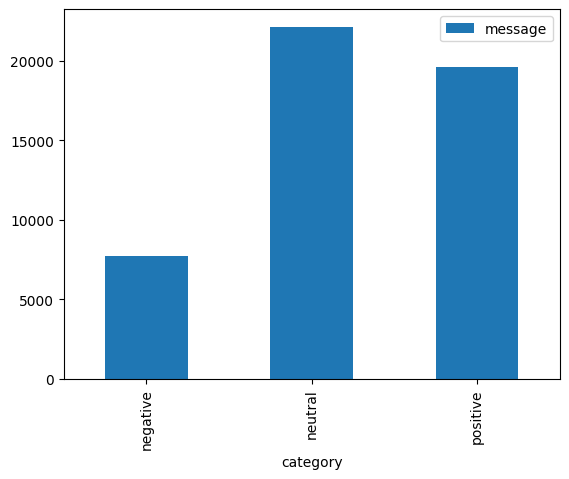

In [5]:
tweets_df.groupby('category').agg({'message': 'count'}).plot.bar()

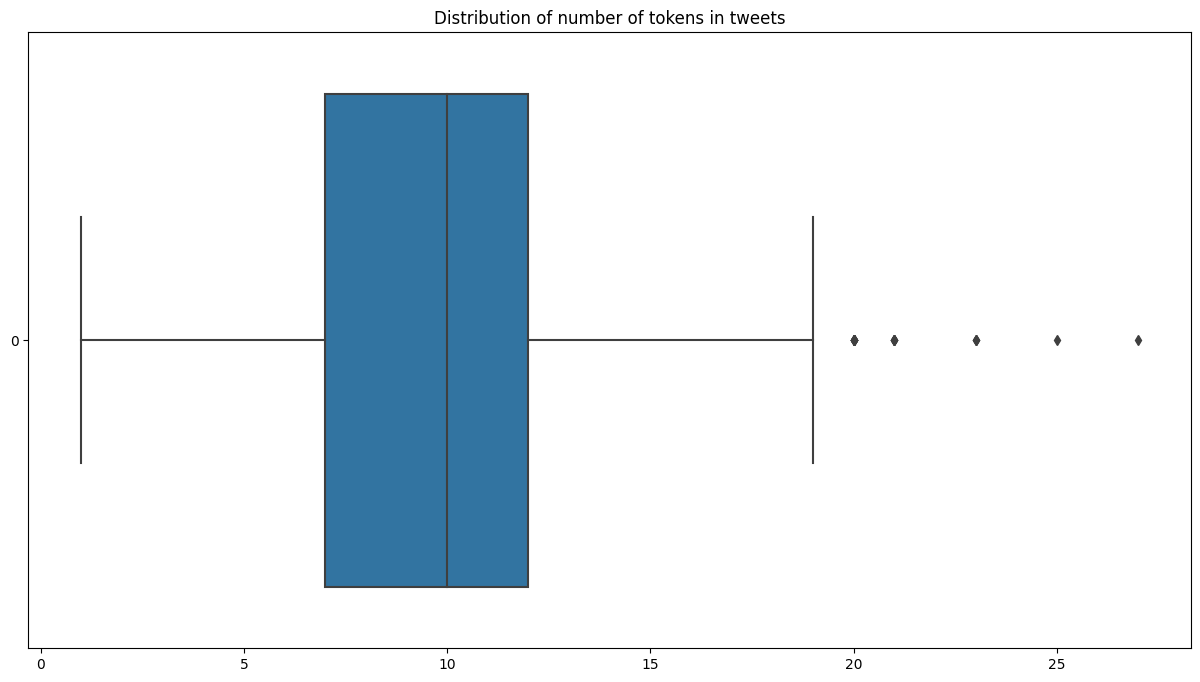

In [6]:
text_lens = [len(t.split()) for t in tweets_df['message'].values]
len_mean = np.mean(text_lens)

plt.figure(figsize=(15,8))
plt.title("Distribution of number of tokens in tweets")
sns.boxplot(text_lens, orient="h")
# sns.histplot(text_lens, bins=10, kde=True, ax=axes[1])
# axes[1].vlines(len_mean, 0, 5000, color='r')
plt.annotate('mean', xy=(len_mean, 5000), xytext=(len_mean - 2, 5050), color='r')

plt.show()

In [7]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler()
X_train_balanced, y_train_balanced = oversampler.fit_resample(np.array(tweets_df['message']).reshape(-1, 1),
                                                             np.array(tweets_df['label']).reshape(-1, 1))
tweets_df_balanced = pd.DataFrame(list(zip([x[0] for x in X_train_balanced], y_train_balanced)), columns=['message', 'label'])
tweets_df_balanced

,message,label
0,arirang simply kpop kim hyung jun cross ha yeo...,1
1,read politico article donald trump running mat...,1
2,type bazura project google image image photo d...,1
3,fast lerner subpoena tech guy work hillary pri...,1
4,sony reward app like lot female singer non ret...,0
...,...,...
66412,die hear track beyonce version bitch watch thr...,2
66413,puzzle promote ibm machine accessory november ...,2
66414,rest peace lee soo man wife deep condolence be...,2
66415,oh yes italy vacation august incl soccer team,2


In [108]:
tweets_df_balanced['label'].value_counts()

1    22139
0    22139
2    22139
Name: label, dtype: int64

In [109]:
X_train, X_test, y_train, y_test = train_test_split(tweets_df_balanced['message'], tweets_df_balanced['label'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, X_val.shape

((47819,), (13284,), (5314,))

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(sublinear_tf=True,
#                              min_df=5,
#                              ngram_range=(1,2),
#                              stop_words='english',
#                              max_features=5000)
vectorizer = CountVectorizer(min_df=5,
                            stop_words='english',
                            max_features=5000)

X_train_vectorized_ = vectorizer.fit_transform(X_train)
X_test_vectorized_ = vectorizer.transform(X_test)
X_val_vectorized_ = vectorizer.transform(X_val)

In [111]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_vectorized_)

X_train_vectorized_ = tf_transformer.transform(X_train_vectorized_)
X_test_vectorized_ = tf_transformer.transform(X_test_vectorized_)
X_valid_vectorized_ = tf_transformer.transform(X_val_vectorized_)

In [112]:
# X_train_vectorized = torch.from_numpy(X_train_vectorized_.toarray()).float()
# X_test_vectorized = torch.from_numpy(X_test_vectorized_.toarray()).float()
# X_val_vectorized = torch.from_numpy(X_val_vectorized_.toarray()).float()

In [113]:
X_train_vectorized = torch.tensor(scipy.sparse.csr_matrix.todense(X_train_vectorized_), dtype=torch.float32)
X_test_vectorized = torch.tensor(scipy.sparse.csr_matrix.todense(X_test_vectorized_), dtype=torch.float32)
X_val_vectorized = torch.tensor(scipy.sparse.csr_matrix.todense(X_val_vectorized_), dtype=torch.float32)

In [114]:
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)
y_val = torch.tensor(y_val.values)

In [115]:
y_train.shape

torch.Size([47819])

In [116]:
X_train_vectorized.shape, X_test_vectorized.shape, X_val_vectorized.shape

(torch.Size([47819, 5000]),
 torch.Size([13284, 5000]),
 torch.Size([5314, 5000]))

In [117]:
# from sklearn.feature_selection import chi2

# N = 10
# labels = tweets_df['label']
# features = vectorizer.fit_transform(X_train).toarray()

# for label in set(tweets_df['label']):
#     features_chi2 = chi2(features, label)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(vectorizer.get_feature_names_out())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
#     print("\n==> %s:" % (label))
#     print("  * Most Correlated Unigrams are: %s " % (', '.join(unigrams[-N:])))
#     print("  * Most Correlated Bigrams are : %s " % (', '.join(bigrams[-N:])))
    

In [118]:
import re

tweets_len = {'Positive': [],
              'Neutral': [],
              'Negative': []}

pattern = re.compile('[^\w ]')
tweets_len = pd.DataFrame([len(re.sub(pattern, '', text).lower().split()) for text in tweets_df['message']], columns=['len'])
tweets_len['target'] = tweets_df['label']

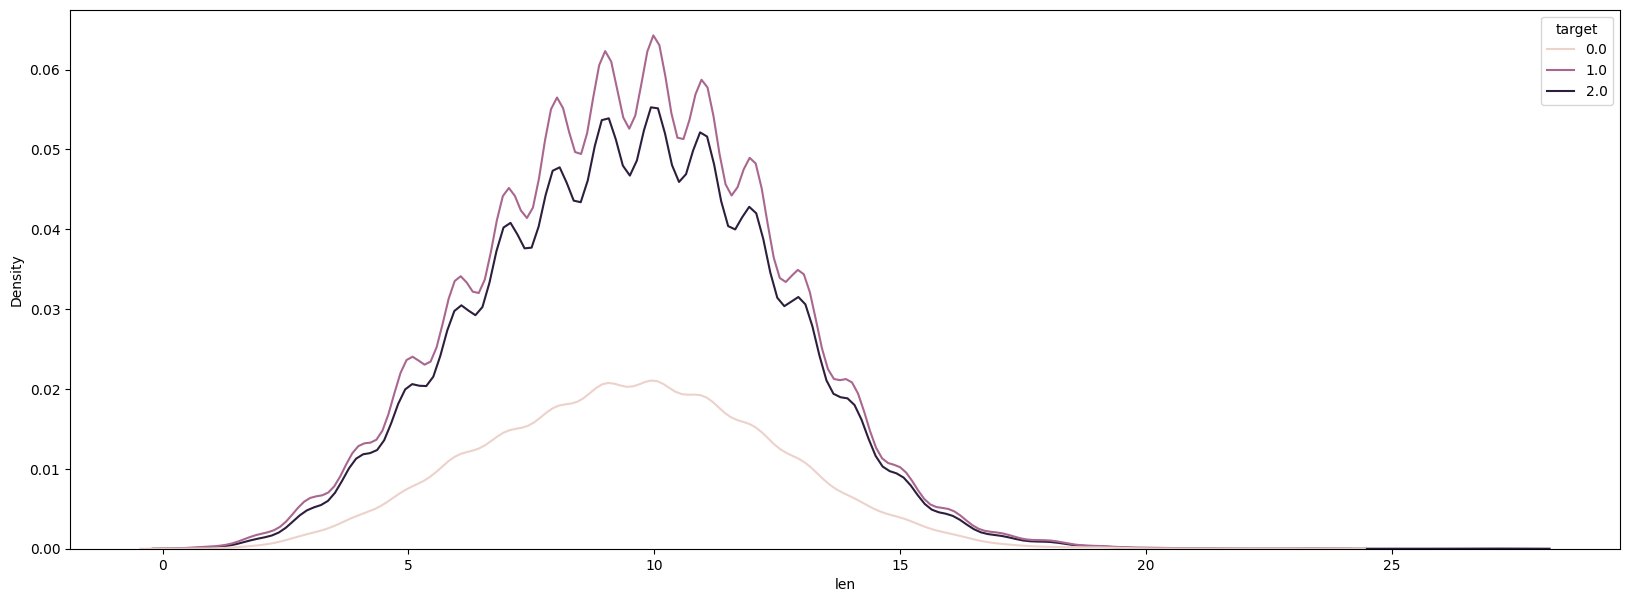

In [119]:
plt.figure(figsize=(20, 7))
sns.kdeplot(data= tweets_len, x='len', hue='target')
plt.show()

Preprocessing

In [120]:
# vectorizer = TfidfVectorizer(sublinear_tf=True,
#                              min_df=5,
#                              ngram_range=(1,2),
#                              stop_words='english',
#                              max_features=10000)

# X_train_vectorized = vectorizer.fit_transform(X_train)
# X_train_vectorized = pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=vectorizer.get_feature_names_out())

# X_valid_vectorized = vectorizer.transform(X_val)
# X_valid_vectorized = pd.DataFrame.sparse.from_spmatrix(X_valid_vectorized, columns=vectorizer.get_feature_names_out())

# X_test_vectorized = vectorizer.transform(X_test)
# X_test_vectorized = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=vectorizer.get_feature_names_out())

In [121]:
# X_train_vectorized.shape, X_test_vectorized.shape, X_valid_vectorized.shape

### Train with Scikit-learn

In [122]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import uniform, randint
from sklearn.model_selection import KFold

In [123]:
def train_cv(model, X_train, y_train, params, n_splits=5, 
             scoring='f1_weighted'):
    kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    
    cv = RandomizedSearchCV(model, params,
                           cv=kf, scoring=scoring,
                           return_train_score=True,
                           n_jobs=-1, verbose=2,
                           random_state=1)
    
    cv.fit(X_train, y_train)
    
    print("Best params: ", cv.best_params_)
    return cv

In [124]:
rs_parameters = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'C': uniform(scale=10),
    'solver': ['newton-og',' lbfgs', 'liblinear', 'saga'],
    'l1_ratio': uniform(scale=10)
}

**1. Train without feature selection**

In [125]:
nb_clf = MultinomialNB()

nb_clf.fit(X_train_vectorized_, y_train)
preds = nb_clf.predict(X_test_vectorized_)

In [126]:
print('\tClassification Report for Naive Bayes:\n\n',
      classification_report(y_test,preds, target_names=['Negative', 'Neutral', 'Positive']))


	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.67      0.70      0.69      4359
     Neutral       0.57      0.49      0.52      4411
    Positive       0.63      0.69      0.66      4514

    accuracy                           0.63     13284
   macro avg       0.62      0.63      0.62     13284
weighted avg       0.62      0.63      0.62     13284



In [127]:
lr = LogisticRegression()

model_cv_lr = train_cv(lr, X_train_vectorized_, y_train, rs_parameters)

best_estimator_lr = model_cv_lr.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\JBOTOY\envs\mle\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JBOTOY\envs\mle\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JBOTOY\envs\mle\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\JBOTOY\envs\mle\lib\site-packages\sklearn\linear_model\_logistic.py", line 48, in _check_solver
    raise ValueError(
ValueE

Best params:  {'C': 3.8791074116200743, 'l1_ratio': 6.6974603680348, 'penalty': 'l1', 'solver': 'liblinear'}


In [128]:
print(classification_report(y_test, best_estimator_lr.predict(X_test_vectorized_)))

              precision    recall  f1-score   support

           0       0.71      0.76      0.74      4359
           1       0.58      0.58      0.58      4411
           2       0.69      0.66      0.67      4514

    accuracy                           0.66     13284
   macro avg       0.66      0.66      0.66     13284
weighted avg       0.66      0.66      0.66     13284



**Build data loader**

In [129]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class TweetsDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

### Build Model

In [130]:
import torch.nn.functional as F

class CReLU(nn.Module):
    def __init__(self):
        super(CReLU, self).__init__()
    def forward(self, x):
        return torch.cat((F.relu(x), F.relu(-x)), 1)

In [131]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.fc1 = nn.Linear(X_train_vec.shape[1], 256)
        self.fc_out = nn.Linear(256, self.out_dim)
        self.activation = CReLU()
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        y = self.fc_out(x)
#         print(y)
        y = self.activation(y)
#         print(y)

        y = self.softmax(y)
        
        return y

In [132]:
class NNSentimentClassifier(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.2)
        self.activation = nn.ReLU()
        self.tanh = nn.Tanh()
        
        self.fc1 = nn.Linear(in_dim, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1000)
        self.fc4 = nn.Linear(1000, 10)
        self.fc_out = nn.Linear(10, out_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        y = self.fc_out(x)
#         y = self.softmax(y)
        
        return y

In [133]:
model = NNSentimentClassifier(X_train_vectorized.shape[1], tweets_df['category'].nunique())

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [134]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_params(model):,} trainable parameters.")

The model has 5,212,143 trainable parameters.


**Define train function**

In [135]:
# train_data_sparse = pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_, columns=vectorizer.get_feature_names_out())
# train_data_sparse

In [136]:
def train(model, train_loader, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    
    model.train()
    
    loop = tqdm(train_loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        
        optimizer.zero_grad()

        preds = model.forward(data).squeeze(1)

        loss = criterion(preds, targets)

        acc = (preds.argmax(1) == targets).sum()

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        total += targets.size(0)
        
    return epoch_loss / total, epoch_acc / total

In [137]:
def evaluate(model, valid_loader, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    total = 0 
    
    model.eval()
    
    with torch.no_grad():
        
        for batch_idx, (data, target) in enumerate(valid_loader):

            preds = model.forward(data).squeeze(1)

            loss = criterion(preds, target)

            acc = (preds.argmax(1) == target).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            total += target.size(0)
        
    return epoch_loss / total, epoch_acc / total

In [138]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Train the model

In [139]:
N_EPOCHS = 20

best_valid_loss = float('inf')

BATCH_SIZE = 64

train_tweets_dataset = TweetsDataset(x = X_train_vectorized, y = y_train)
valid_tweets_dataset = TweetsDataset(x = X_val_vectorized, y = y_val)

train_loader = DataLoader(train_tweets_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle=True,
                          drop_last=False)
valid_loader = DataLoader(valid_tweets_dataset,
                         batch_size = 1,
                         shuffle=True,
                         drop_last=False)

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'models/nlp_tfidf_model.pt')
        
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [00:57<00:00, 13.06it/s]


Epoch: 01 | Epoch Time: 1m 5s
	Train Loss: 0.014 | Train Acc: 57.46%
	 Val. Loss: 2.143 |  Val. Acc: 53.65%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:02<00:00, 12.04it/s]


Epoch: 02 | Epoch Time: 1m 10s
	Train Loss: 0.009 | Train Acc: 75.92%
	 Val. Loss: 8.331 |  Val. Acc: 41.74%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:19<00:00,  9.44it/s]


Epoch: 03 | Epoch Time: 1m 27s
	Train Loss: 0.005 | Train Acc: 86.47%
	 Val. Loss: 20.861 |  Val. Acc: 39.12%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:12<00:00, 10.26it/s]


Epoch: 04 | Epoch Time: 1m 21s
	Train Loss: 0.003 | Train Acc: 92.71%
	 Val. Loss: 26.091 |  Val. Acc: 39.65%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:24<00:00,  8.85it/s]


Epoch: 05 | Epoch Time: 1m 34s
	Train Loss: 0.002 | Train Acc: 95.06%
	 Val. Loss: 28.877 |  Val. Acc: 39.14%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:19<00:00,  9.42it/s]


Epoch: 06 | Epoch Time: 1m 29s
	Train Loss: 0.001 | Train Acc: 96.29%
	 Val. Loss: 34.774 |  Val. Acc: 39.41%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:21<00:00,  9.21it/s]


Epoch: 07 | Epoch Time: 1m 30s
	Train Loss: 0.001 | Train Acc: 96.62%
	 Val. Loss: 32.326 |  Val. Acc: 40.55%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:15<00:00,  9.97it/s]


Epoch: 08 | Epoch Time: 1m 23s
	Train Loss: 0.001 | Train Acc: 96.86%
	 Val. Loss: 44.483 |  Val. Acc: 39.20%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:14<00:00,  9.99it/s]


Epoch: 09 | Epoch Time: 1m 24s
	Train Loss: 0.001 | Train Acc: 96.95%
	 Val. Loss: 48.242 |  Val. Acc: 40.63%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:17<00:00,  9.60it/s]


Epoch: 10 | Epoch Time: 1m 26s
	Train Loss: 0.001 | Train Acc: 96.62%
	 Val. Loss: 62.097 |  Val. Acc: 41.42%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:18<00:00,  9.55it/s]


Epoch: 11 | Epoch Time: 1m 26s
	Train Loss: 0.001 | Train Acc: 96.95%
	 Val. Loss: 67.019 |  Val. Acc: 42.17%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:20<00:00,  9.25it/s]


Epoch: 12 | Epoch Time: 1m 30s
	Train Loss: 0.001 | Train Acc: 97.26%
	 Val. Loss: 73.843 |  Val. Acc: 40.97%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:17<00:00,  9.68it/s]


Epoch: 13 | Epoch Time: 1m 26s
	Train Loss: 0.001 | Train Acc: 97.35%
	 Val. Loss: 54.341 |  Val. Acc: 41.51%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:15<00:00,  9.87it/s]


Epoch: 14 | Epoch Time: 1m 26s
	Train Loss: 0.001 | Train Acc: 97.39%
	 Val. Loss: 69.508 |  Val. Acc: 40.95%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:20<00:00,  9.31it/s]


Epoch: 15 | Epoch Time: 1m 30s
	Train Loss: 0.001 | Train Acc: 97.21%
	 Val. Loss: 60.751 |  Val. Acc: 40.67%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:15<00:00,  9.92it/s]


Epoch: 16 | Epoch Time: 1m 24s
	Train Loss: 0.001 | Train Acc: 97.57%
	 Val. Loss: 73.847 |  Val. Acc: 39.54%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:15<00:00,  9.87it/s]


Epoch: 17 | Epoch Time: 1m 24s
	Train Loss: 0.001 | Train Acc: 97.56%
	 Val. Loss: 74.855 |  Val. Acc: 41.08%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:13<00:00, 10.15it/s]


Epoch: 18 | Epoch Time: 1m 22s
	Train Loss: 0.001 | Train Acc: 97.82%
	 Val. Loss: 78.556 |  Val. Acc: 41.14%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:16<00:00,  9.75it/s]


Epoch: 19 | Epoch Time: 1m 24s
	Train Loss: 0.001 | Train Acc: 97.75%
	 Val. Loss: 63.873 |  Val. Acc: 42.21%


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [01:16<00:00,  9.81it/s]


Epoch: 20 | Epoch Time: 1m 29s
	Train Loss: 0.001 | Train Acc: 97.53%
	 Val. Loss: 62.304 |  Val. Acc: 41.00%


In [140]:
test_tweets_dataset = TweetsDataset(x=X_test_vectorized, y=y_test)
test_loader = DataLoader(test_tweets_dataset,
                        batch_size=1,
                        shuffle=False,
                        drop_last=False)

test_loss, test_accuracy = evaluate(model, test_loader, criterion)

print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.4f}".format(test_accuracy))

Test Loss: 2.2310
Test Accuracy: 0.7640


In [141]:
for (data, target) in train_loader:
    print(len(target))
    break

64


In [142]:
from torch.autograd import Variable
import gc
import torch.nn.functional as F

def make_predictions(model, loader):
    y_shuffled, y_preds = [], []
    
    with torch.no_grad():
        
        for X, y in loader:
            
            X = Variable(X).to(device)
            y = Variable(y).to(device)
            
            preds = model(X)
            y_preds.append(preds)
            y_shuffled.append(y)
        gc.collect()
        y_preds, y_shuffled = torch.cat(y_preds), torch.cat(y_shuffled)
        
        # host memory to cpu prioir to conversion
        y_preds = y_preds.cpu()
        y_shuffled = y_shuffled.cpu()
        
        return y_shuffled.detach().numpy(), F.softmax(y_preds, dim=-1).argmax(dim=-1).detach().numpy()
    
y_actual, y_preds = make_predictions(model, test_loader)

In [143]:
from sklearn.metrics import accuracy_score, classification_report

target_classes = ['Negative', 'Neutral', 'Positive']

print("Test accuracy: {:.4f}".format(accuracy_score(y_actual, y_preds)))
print("\nClassification Report: ")
print(classification_report(y_actual, y_preds, target_names=target_classes))
print("\nConfusion Matrix: ")
print(confusion_matrix(y_actual, y_preds))

Test accuracy: 0.7640

Classification Report: 
              precision    recall  f1-score   support

    Negative       0.92      0.90      0.91      4359
     Neutral       0.63      0.79      0.70      4411
    Positive       0.79      0.61      0.69      4514

    accuracy                           0.76     13284
   macro avg       0.78      0.77      0.77     13284
weighted avg       0.78      0.76      0.76     13284


Confusion Matrix: 
[[3928  368   63]
 [ 261 3482  668]
 [  72 1703 2739]]


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

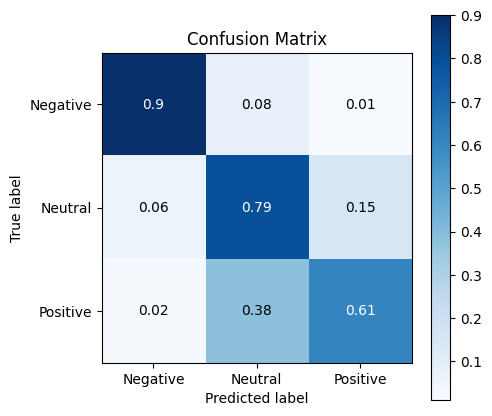

In [144]:
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in y_actual], 
                                    [target_classes[i] for i in y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap='Blues',
                                    hide_zeros=True,
                                    figsize=(5,5))

In [145]:
torch.save(model.state_dict(), 'models/nlp_tfidf_model_v2.pt')

model_saved = NNSentimentClassifier(X_train_vectorized.shape[1], tweets_df['category'].nunique())
model_saved.load_state_dict(torch.load("models/nlp_tfidf_model_v2.pt"))
test_loss, test_acc = evaluate(model_saved, test_loader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 2.231 | Test Acc: 76.40%


In [55]:
test_data = list(zip(X_test, y_test))
test_data

[('when the best talent is on internship temasekpoly sony is coming to tp this friday to look for student talent',
  tensor(1)),
 ('watching amy schumer live at the apollo make me so excited for sunday when kentstateusg brings amyschumer',
  tensor(1)),
 ('tony blair more like baloney tear you may notice from my incredulous tone and use of insulting wordplay that the glove are off',
  tensor(-1)),
 ('i think those that care about newcastle utd really need to stop this happening httptcosrzvyl',
  tensor(-1)),
 ('via captainneon ted r july pm ted r pm minor with parent or guardian ticket on httptconjsfpfpzm',
  tensor(0)),
 ('rick perry may have to drop out of the race before one vote is cast because he ha run out of money i have mixed feeling about that',
  tensor(-1)),
 ('markbritball bbl to take over cheshirejets franchise in shortterm game with mersey this sunday to go ahead h httptcoddvwufr',
  tensor(0)),
 ('tiaxmariex must think youre frank ocean delaying the release till tomorrow

In [61]:
X_test_text, y_test = [], []
for X, y in test_data:
    X_test_text.append(X)
    y_test.append(y-1)

len(X_test_text)

13337

In [94]:
from lime import lime_text

explainer = lime_text.LimeTextExplainer(class_names=target_classes)
max_words = 30

def predict_batch(X_batch_text):
    X = [vectorizer.transform([text]).toarray() for text in X_batch_text]
    
    # bringing all samples to max_words length
#     X = [tokens + ([0] * (max_words - tokens.shape[0])) if tokens.shape[0] < max_words else tokens[:max_words] for tokens in X] 
    logits = model.forward(torch.tensor(X, dtype=torch.float32).to(device))
    preds = F.softmax(logits, dim=-1)
    preds = preds.cpu()
    
    return preds.detach().numpy()

# Randomly select test examples and make predictions
rng = np.random.RandomState(65)
idx = rng.randint(1, len(X_test_text))
X = [vectorizer.transform([text]).toarray() for text in X_test_text[idx:idx+1]]

print(X)

# bring all samples to max_words length
# X = [tokens + ([0] * (max_words - tokens.shape[0])) if tokens.shape[0] < max_words else tokens[:max_words] for tokens in X]
preds = model(torch.tensor(X, dtype=torch.float32).to(device))
preds = F.softmax(preds, dim=-1)

print("Prediction: ", target_classes[preds.argmax()])
print("Actual: ", target_classes[y_test[idx]])

[array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)]
Prediction:  Negative
Actual:  Negative


In [96]:
y_test[idx:idx+1]

[tensor(0)]

In [97]:
y_test_ = [int(x) for x in y_test ]
y_test_[idx:idx+1]

[0]

In [50]:
X_test_text[idx]

'at least dustin johnson didnt wait til the final round to implode guess he didnt get the memo that sunday wa actually the rd round'

In [98]:
explanation = explainer.explain_instance(X_test_text[idx], classifier_fn=predict_batch,
                                        labels=y_test_[idx:idx+1])
explanation.show_in_notebook()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
for text in X_test_text[idx:idx+1]:
    print(vectorizer.transform([text]))
    break